## Imports and functions

In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
    temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
    temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
    temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])

def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date
        agg_df[f'{env_type}-{week}_weeks_before_transfer-{function_name}'] = ph_df[before_transfer & condition]\
        .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df

def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

def plot_swarm(df, factor, target, bins, y_scale=1):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
    mean_main_factor = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()

#     vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
        box_plot.text(xtick,
                      mean_main_factor.iloc[xtick] / y_scale,
                      round(mean_main_factor.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='darkblue',
                      weight='semibold')
    
    plt.title(f'Swarmplot: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'swarmplot_{target}_vs_{factor}.jpg')

## Data processing

In [3]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/temperature_for_CAM.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final_locus.csv',
                       mortality_path='../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].mean())
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

In [4]:
feed_data = pd.read_csv('feed_data_daily.csv')

In [15]:
sw_fw_matching_with_cnt

,to_locus_id,to_fish_group_id,transfer_date,from_locus_population_id,from_count_stocking,from_locus_id,from_year_class,from_avg_weight,from_fish_group_id,transfer_year
0,3046025,520,2008-03-20,36705857,77196,3047424,2007,109,1189,2008
1,3046036,80,2015-01-30,36760186,47054,3051294,2014,116,153,2015
2,3046036,11,2017-01-03,36774243,45121,3049067,2016,113,671,2017
3,3046036,1052,2019-01-15,36789742,22090,3050198,2018,134,948,2019
4,3046036,1052,2019-01-15,36789724,24410,3047918,2018,123,948,2019
...,...,...,...,...,...,...,...,...,...,...
8404,7189886,6215,2023-04-10,194655920,3212,7185841,2022,418,6133,2023
8405,7189886,6215,2023-04-10,194741287,6207,7185841,2022,418,6133,2023
8406,7189886,6215,2023-04-10,194741271,6355,7185841,2022,418,6133,2023
8407,7189886,6215,2023-05-18,194741280,3189,7185840,2022,362,6133,2023


In [5]:
feed_data

,final_locus_population_id,event_date,amount,SFR,FCR,SGR,open_count,open_weight_g,close_count,close_weight_g
0,36783130,2017-08-14,0.070000,0.014096,0.171359,8.333333,41383.000000,0.120000,41342.000000,0.130000
1,36783130,2017-08-15,0.119669,0.025327,0.304446,8.333333,39058.890070,0.120000,39053.442879,0.130000
2,36783130,2017-08-16,0.100000,0.020491,0.246134,8.333333,40708.073787,0.120000,40705.038728,0.130000
3,36783130,2017-08-17,0.186432,0.037050,0.461975,8.102684,40850.632609,0.123598,40830.690188,0.133598
4,36783130,2017-08-18,0.184174,0.035230,0.468456,7.685063,39260.958724,0.130501,39246.278677,0.140501
...,...,...,...,...,...,...,...,...,...,...
927930,194650523,2023-02-25,60.000000,0.003282,0.998469,0.330150,71842.000000,254.430000,71841.000000,255.270000
927931,194650523,2023-02-26,60.000000,0.003282,0.998469,0.330150,71842.000000,254.430000,71841.000000,255.270000
927932,194650523,2023-02-27,60.000000,0.003282,0.998469,0.330150,71842.000000,254.430000,71841.000000,255.270000
927933,194650523,2023-02-28,60.000000,0.003282,0.998469,0.330150,71842.000000,254.430000,71841.000000,255.270000


In [6]:
feed_data_with_dates = feed_data.merge(
    fresh_water_dates,
    how='inner',
)

feed_data_with_dates = feed_data_with_dates.merge(
    vaccines_agg,
    left_on='final_locus_population_id',
    right_on='FINAL_LOCUS_POPULATION_ID',
    how='inner'
)

feed_data_with_dates['shipout_year'] = feed_data_with_dates['shipout_date'].dt.year

In [7]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [8]:
before_transfer = feed_data_with_dates['event_date'] < feed_data_with_dates['shipout_date']
after_vaccination = feed_data_with_dates['event_date'] > feed_data_with_dates['VAC_EVENT_DATE']
after_first_feeding = feed_data_with_dates['event_date'] > feed_data_with_dates['first_feeding_date']

six_weeks_condition = feed_data_with_dates['event_date'] > (feed_data_with_dates['shipout_date'] - pd.to_timedelta(6, unit='W'))
eight_weeks_condition = feed_data_with_dates['event_date'] > (feed_data_with_dates['shipout_date'] - pd.to_timedelta(8, unit='W'))
threshold_conditions = {
    '6_weeks_before_transfer': before_transfer & six_weeks_condition,
    '8_weeks_before_transfer': before_transfer & eight_weeks_condition,
    'vaccination_transfer': before_transfer & after_vaccination,
    'first_feeding_transfer': before_transfer & after_first_feeding,
}

weeks_before_transfer = [2, 4, 6, 8]
#name of column with values of the factor
key_columns = ['locus_id','fish_group_id','transfer_year']

## Factors aggregation

#### SGR

In [9]:
main_factor = 'SGR'

In [10]:
agg_functions = {
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
    'cv': lambda x: np.std(x) / np.mean(x),  # coefficient of variation
    'threshold': np.count_nonzero,
}

<AxesSubplot:>

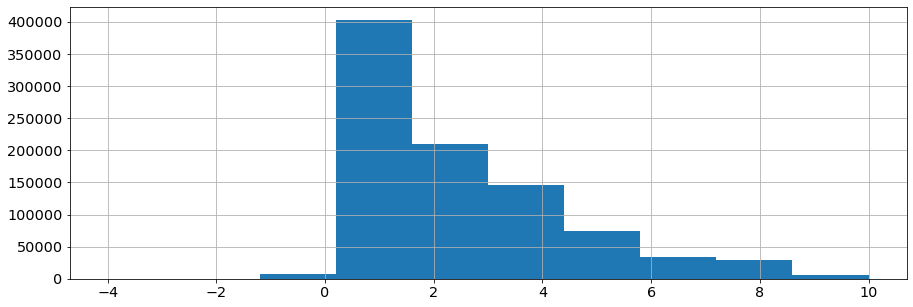

In [11]:
feed_data[feed_data[main_factor] < 10][main_factor].hist()

In [12]:
max_threshold = 5.5
min_threshold = 1
print(f'Min {main_factor} threshold: {min_threshold}, max {main_factor} threshold: {max_threshold}')

Min SGR threshold: 1, max SGR threshold: 5.5


In [13]:
agg_dfs = []

for name, func in tqdm(agg_functions.items()):
    if name != 'threshold':
        agg_df = create_ph_aggregated_factors(feed_data_with_dates,
                                              main_factor,
                                              agg_function=func,
                                              function_name=name,
                                              env_type=main_factor.lower())
        agg_dfs.append(agg_df)
    else:
        for condition_type, condition in threshold_conditions.items():
            agg_df = create_ph_aggregated_factors_threshold(
                feed_data_with_dates[condition],
                main_factor,
                min_threshold,
                max_threshold,
                agg_function=func,
                condition_type=condition_type,
                env_type=main_factor.lower()
            )
            agg_dfs.append(agg_df)
    
agg_df = pd.concat(agg_dfs)

agg_df = agg_df.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='right')

factors = agg_df.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

sgr_factors = create_factors_df(agg_df,
                               factors,
                               key_columns, 
                               weight_column='from_count_stocking',
                               weighted_func=weighted_avg)
sgr_factors = sgr_factors.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner')

sgr_factors = sgr_factors.merge(
    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
    on=key_columns,
    how='inner'
)

sgr_factors.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

sgr_factors.to_csv(f'factors_{main_factor.lower()}.csv', index=False)

100%|█████████████████████████████████████████████| 6/6 [00:50<00:00,  8.37s/it]


In [14]:
agg_df

,sgr-transfer_feeding-mean,sgr-transfer_vaccination-mean,sgr-2_weeks_before_transfer-mean,sgr-4_weeks_before_transfer-mean,sgr-6_weeks_before_transfer-mean,sgr-8_weeks_before_transfer-mean,sgr-transfer_feeding-mean-from_mean,sgr-transfer_feeding-mean-from_mean-abs,sgr-transfer_vaccination-mean-from_mean,sgr-transfer_vaccination-mean-from_mean-abs,...,sgr-vaccination_transfer-btw_min_max-1-5.5,sgr-vaccination_transfer-relative_higher_max-5.5,sgr-vaccination_transfer-relative_lower_min-1,sgr-vaccination_transfer-relative_out_min_max-1-5.5,sgr-first_feeding_transfer-higher_max-5.5,sgr-first_feeding_transfer-lower_min-1,sgr-first_feeding_transfer-btw_min_max-1-5.5,sgr-first_feeding_transfer-relative_higher_max-5.5,sgr-first_feeding_transfer-relative_lower_min-1,sgr-first_feeding_transfer-relative_out_min_max-1-5.5
final_locus_population_id,,,,,,,,,,,,,,,,,,,,,
36783130,3.045948,1.004063,0.505508,0.768017,0.915274,1.033585,-6.563577,6.563577,-0.087575,0.087575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36783339,2.986406,0.757009,0.387573,0.712172,0.792852,0.775968,-6.623118,6.623118,-0.334629,0.334629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36783413,3.310277,1.587694,1.196586,1.595597,1.468103,1.597863,-6.299247,6.299247,0.496056,0.496056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36783453,2.988847,1.261810,0.595385,0.958415,1.125636,1.194647,-6.620677,6.620677,0.170172,0.170172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36783456,3.059645,0.956250,0.720460,0.962530,1.017736,1.019891,-6.549880,6.549880,-0.135388,0.135388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194650512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31.0,49.0,242.0,0.096273,0.152174,0.248447
194650513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31.0,49.0,242.0,0.096273,0.152174,0.248447
194650515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31.0,49.0,242.0,0.096273,0.152174,0.248447


In [25]:
corr_df = pd.DataFrame(sgr_factors[factors].apply(lambda x: x.corr(sgr_factors['TGC_SW'])), columns=['corr'])

highest_corr = corr_df.nlargest(10, columns='corr')
lowest_corr = corr_df.nsmallest(5, columns='corr')

In [26]:
highest_corr

,corr
sgr-6_weeks_before_transfer-btw_min_max-1-5.5,0.287448
sgr-8_weeks_before_transfer-btw_min_max-1-5.5,0.203822
sgr-first_feeding_transfer-relative_higher_max-5.5,0.111239
sgr-transfer_vaccination-min,0.092660
sgr-transfer_vaccination-min-from_mean,0.092660
sgr-transfer_feeding-min,0.091979
sgr-transfer_feeding-min-from_mean,0.091979
sgr-2_weeks_before_transfer-cv-from_mean-abs,0.080118
sgr-vaccination_transfer-relative_higher_max-5.5,0.071997
sgr-2_weeks_before_transfer-cv,0.066972


In [27]:
lowest_corr

,corr
sgr-6_weeks_before_transfer-relative_out_min_max-1-5.5,-0.287448
sgr-6_weeks_before_transfer-lower_min-1,-0.273530
sgr-6_weeks_before_transfer-relative_lower_min-1,-0.273530
sgr-transfer_feeding-cv,-0.235696
sgr-transfer_feeding-cv-from_mean,-0.235696


## Findings

In [28]:
tmp = feed_data_with_dates.merge(mortality_final_locus,
                               left_on='final_locus_population_id',
                               right_on='from_locus_population_id')


sgr_factors = sgr_factors.merge(
    pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
    on=key_columns,
    how='left'
)

### Finding 1: High relative lower min sgr -> Higher mortality 

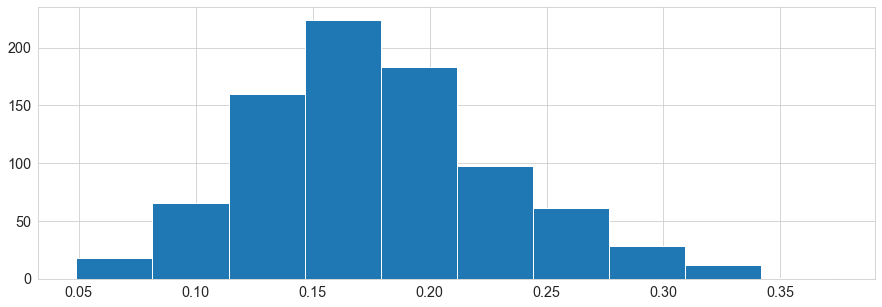

<Figure size 1080x360 with 0 Axes>

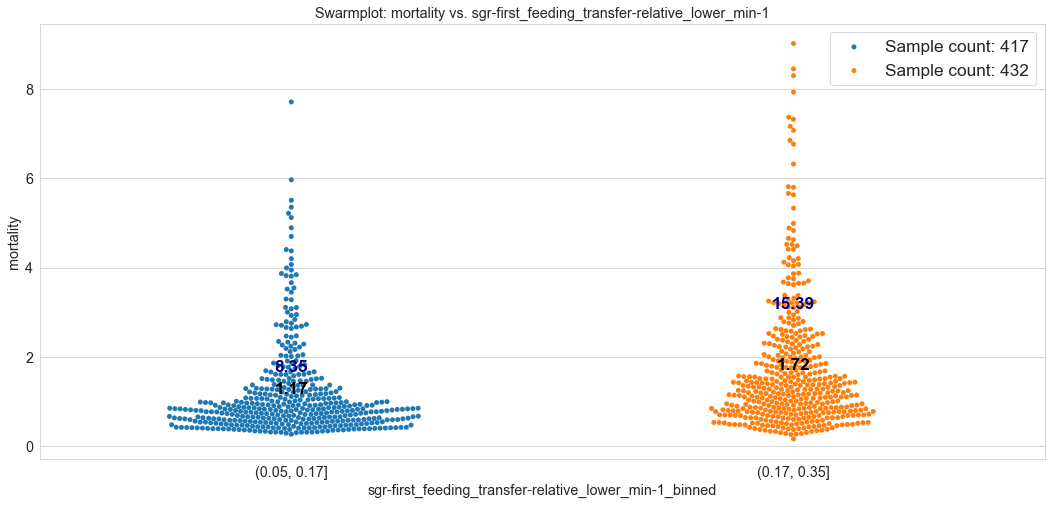

<Figure size 1080x360 with 0 Axes>

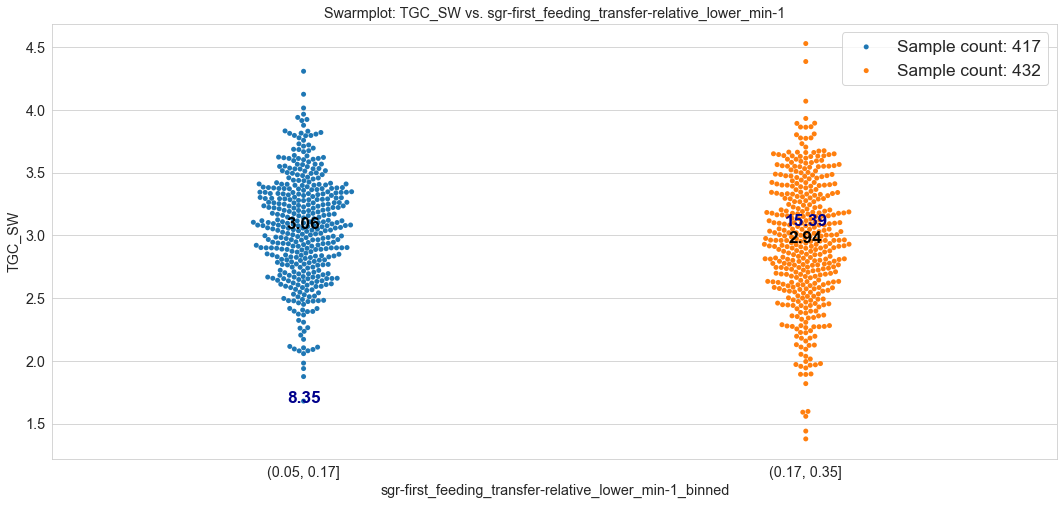

In [54]:
factor = f'{main_factor.lower()}-first_feeding_transfer-relative_lower_min-{min_threshold}'

sgr_factors[factor].hist()
plt.show()

plot_swarm(sgr_factors,
           factor=factor,
           target='mortality',
           bins=(0.05, 0.17, 0.35),
           y_scale=5)

plot_swarm(sgr_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0.05, 0.17, 0.35),
           y_scale=5)

### Finding 2: High relative higher max SGR -> lower mortality

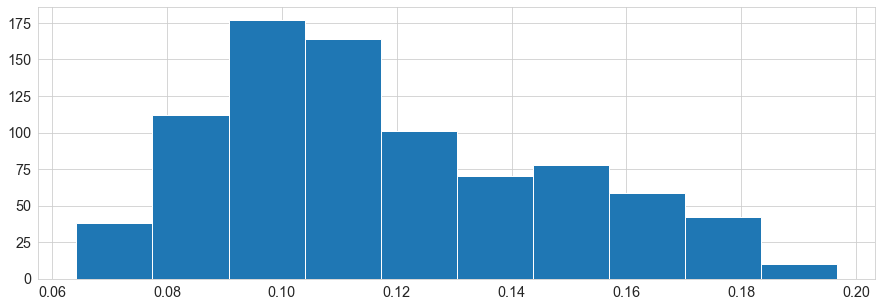

<Figure size 1080x360 with 0 Axes>

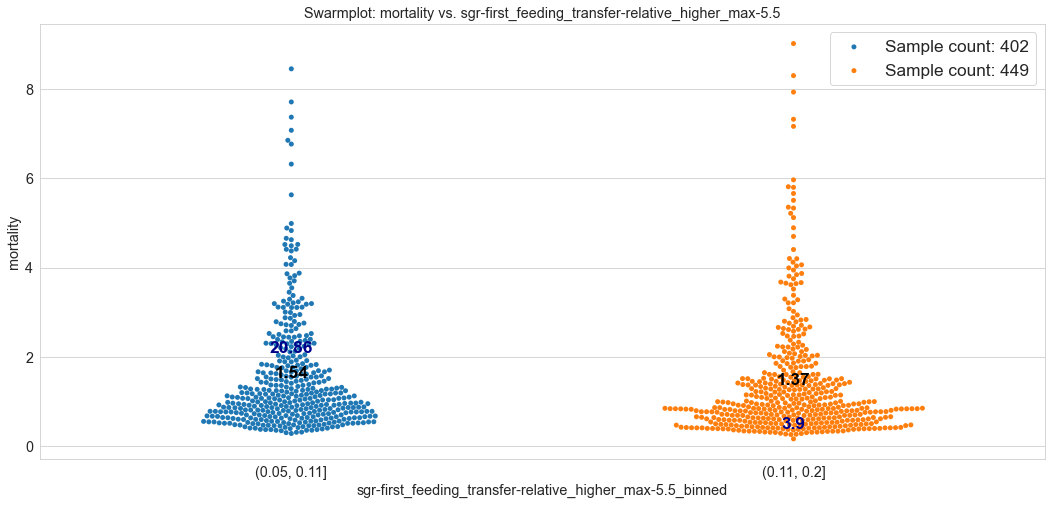

<Figure size 1080x360 with 0 Axes>

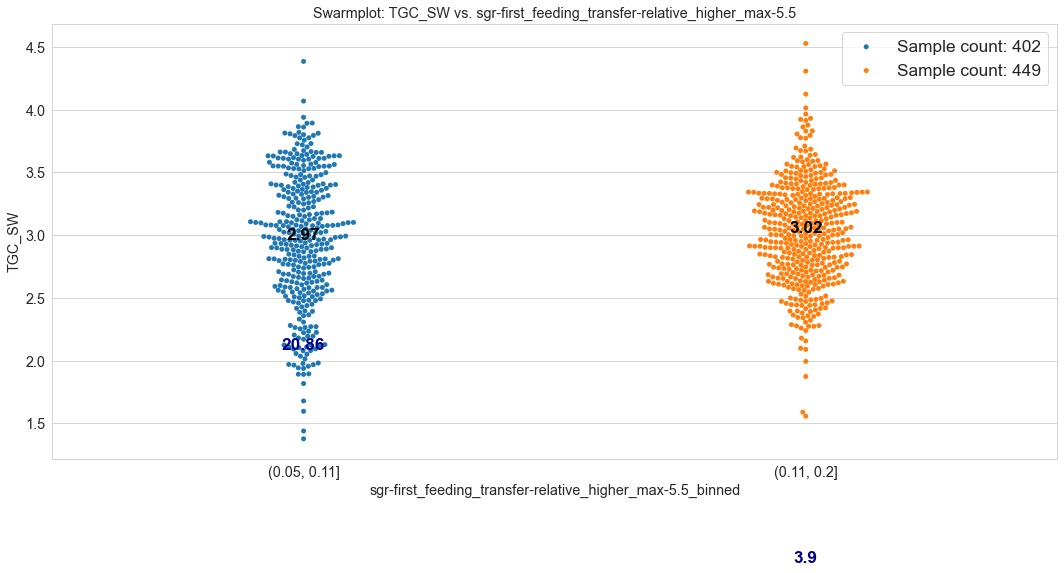

In [61]:
factor = f'{main_factor.lower()}-first_feeding_transfer-relative_higher_max-{max_threshold}'

sgr_factors[factor].hist()
plt.show()

plot_swarm(sgr_factors,
           factor=factor,
           target='mortality',
           bins=(0.05, 0.11, 0.2),
           y_scale=10)

plot_swarm(sgr_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0.05, 0.11, 0.2),
           y_scale=10)

### FInding 3: High Mean SGR -> lower mortality

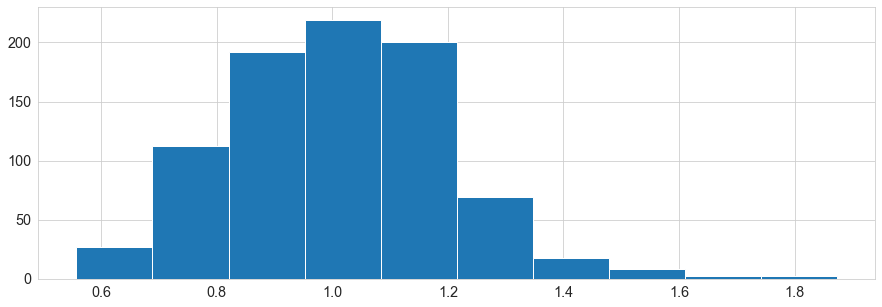

<Figure size 1080x360 with 0 Axes>

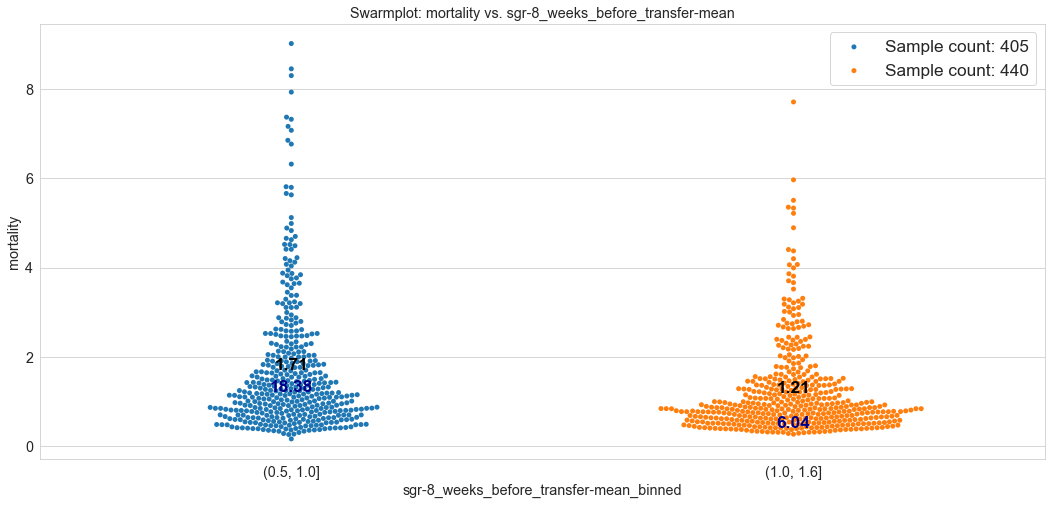

<Figure size 1080x360 with 0 Axes>

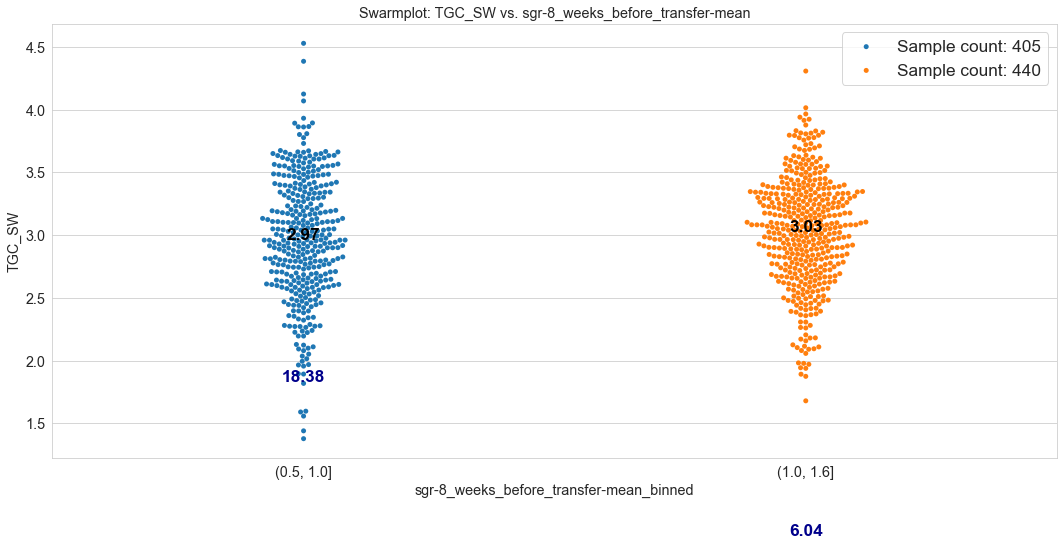

In [76]:
factor = f'{main_factor.lower()}-8_weeks_before_transfer-mean'

sgr_factors[sgr_factors[factor].between(0, 2)][factor].hist()
plt.show()

plot_swarm(sgr_factors,
           factor=factor,
           target='mortality',
           bins=(0.5, 1., 1.6),
           y_scale=15)

plot_swarm(sgr_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0.5, 1., 1.6),
           y_scale=10)

### Finding 4: STD/CV vs Mortality

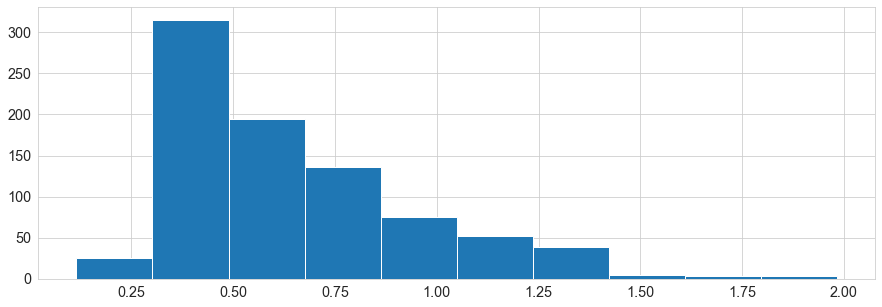

<Figure size 1080x360 with 0 Axes>

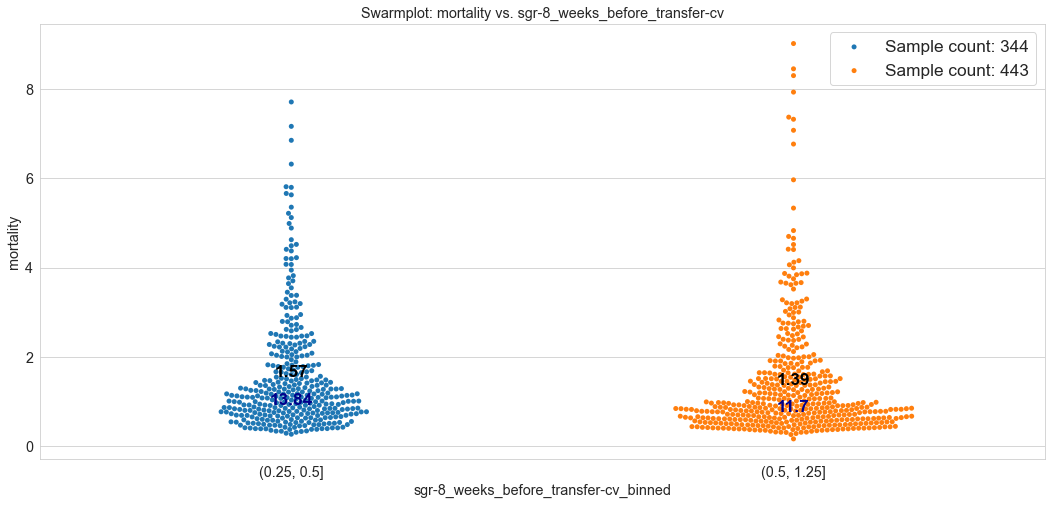

<Figure size 1080x360 with 0 Axes>

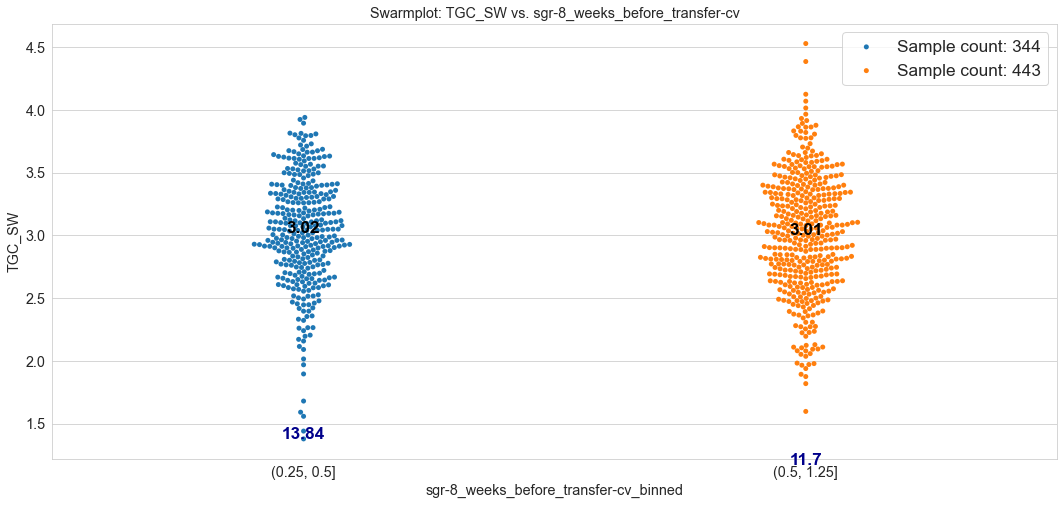

In [78]:
factor = f'{main_factor.lower()}-8_weeks_before_transfer-cv'

sgr_factors[sgr_factors[factor].between(0, 2)][factor].hist()
plt.show()

plot_swarm(sgr_factors,
           factor=factor,
           target='mortality',
           bins=(0.25, 0.5, 1.25),
           y_scale=15)

plot_swarm(sgr_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0.25, 0.5, 1.25),
           y_scale=10)

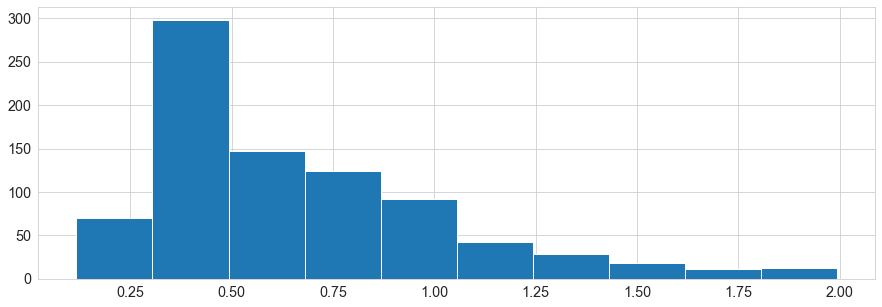

<Figure size 1080x360 with 0 Axes>

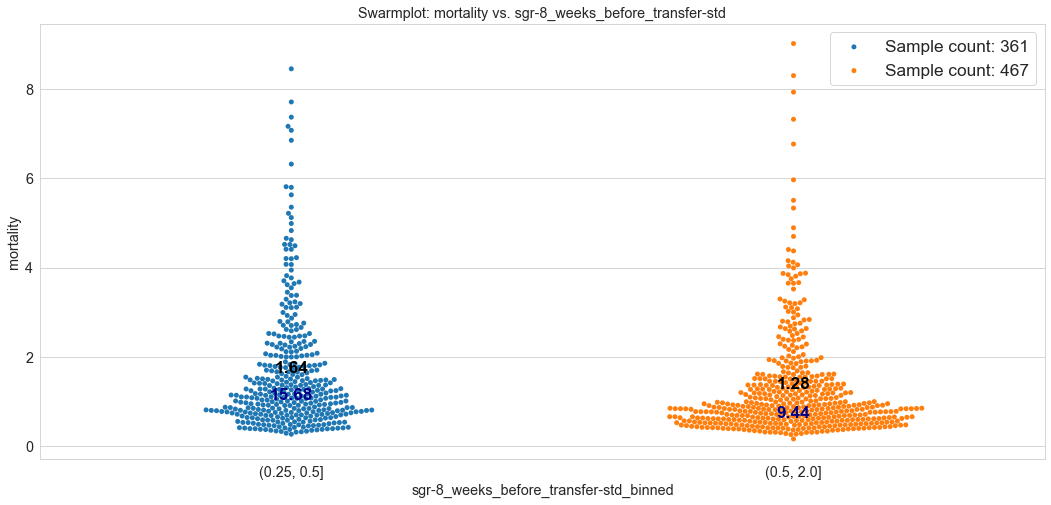

<Figure size 1080x360 with 0 Axes>

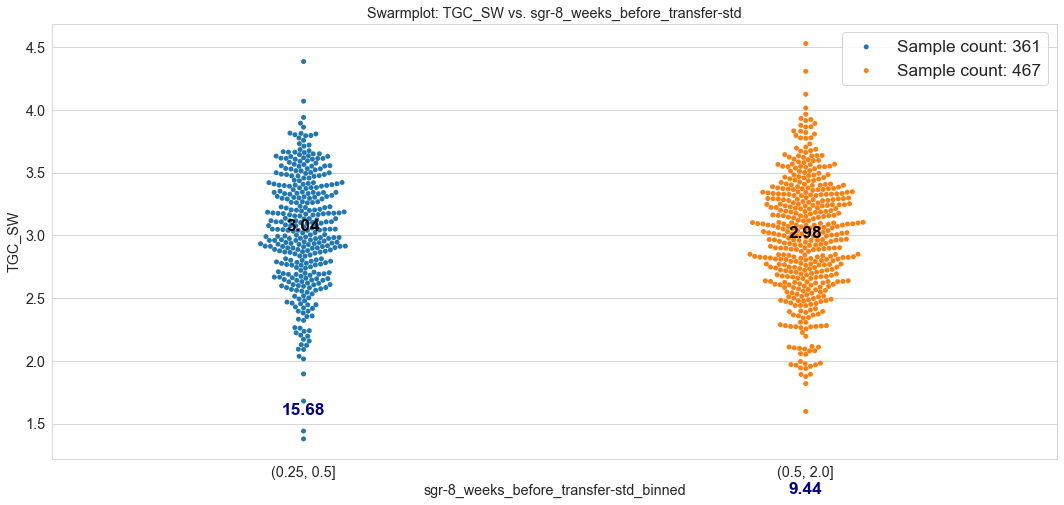

In [81]:
factor = f'{main_factor.lower()}-8_weeks_before_transfer-std'

sgr_factors[sgr_factors[factor].between(0, 2)][factor].hist()
plt.show()

plot_swarm(sgr_factors,
           factor=factor,
           target='mortality',
           bins=(0.25, 0.5, 2),
           y_scale=15)

plot_swarm(sgr_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0.25, 0.5, 2),
           y_scale=10)

### Finding 5:

### Higher max -> lower mortality
### Min has no affect

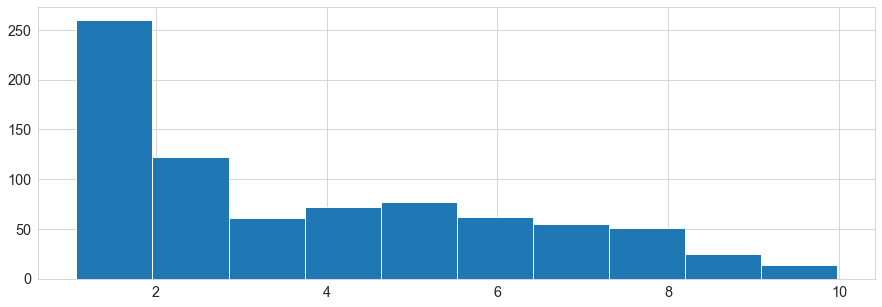

<Figure size 1080x360 with 0 Axes>

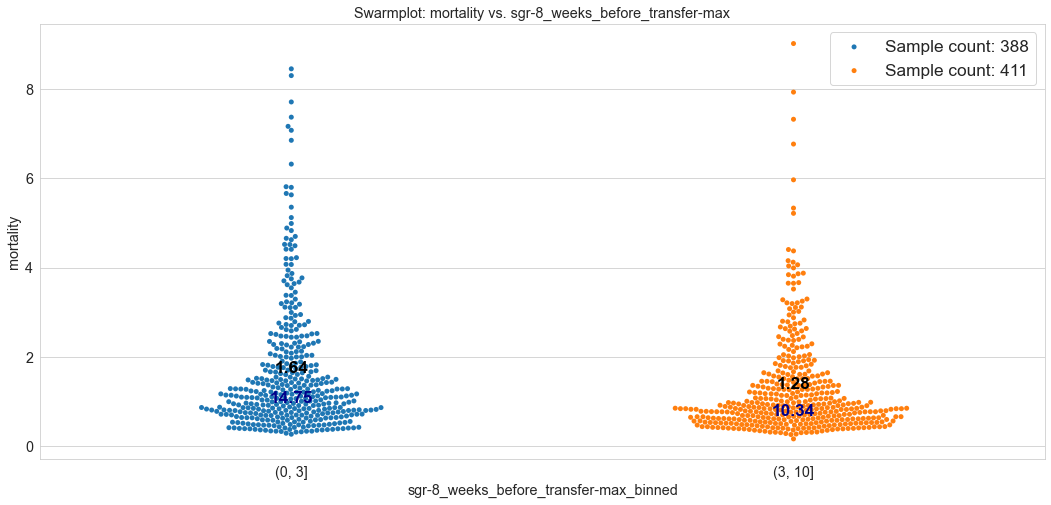

<Figure size 1080x360 with 0 Axes>

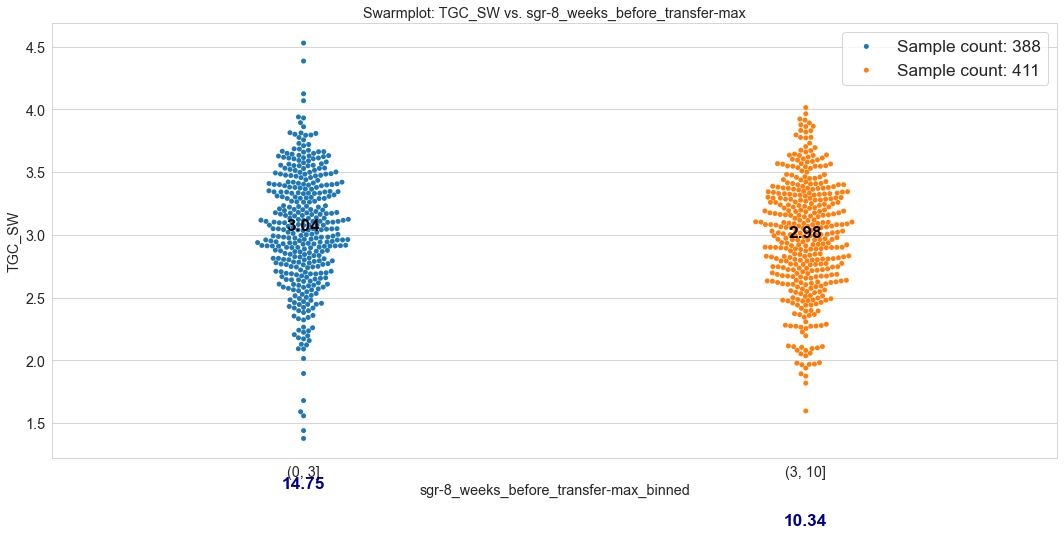

In [90]:
factor = f'{main_factor.lower()}-8_weeks_before_transfer-max'

sgr_factors[sgr_factors[factor].between(1, 10)][factor].hist()
plt.show()

plot_swarm(sgr_factors,
           factor=factor,
           target='mortality',
           bins=(0, 3, 10),
           y_scale=15)

plot_swarm(sgr_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 3, 10),
           y_scale=15)

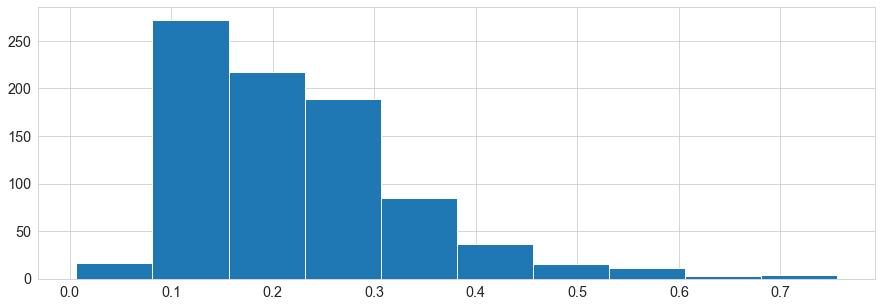

<Figure size 1080x360 with 0 Axes>

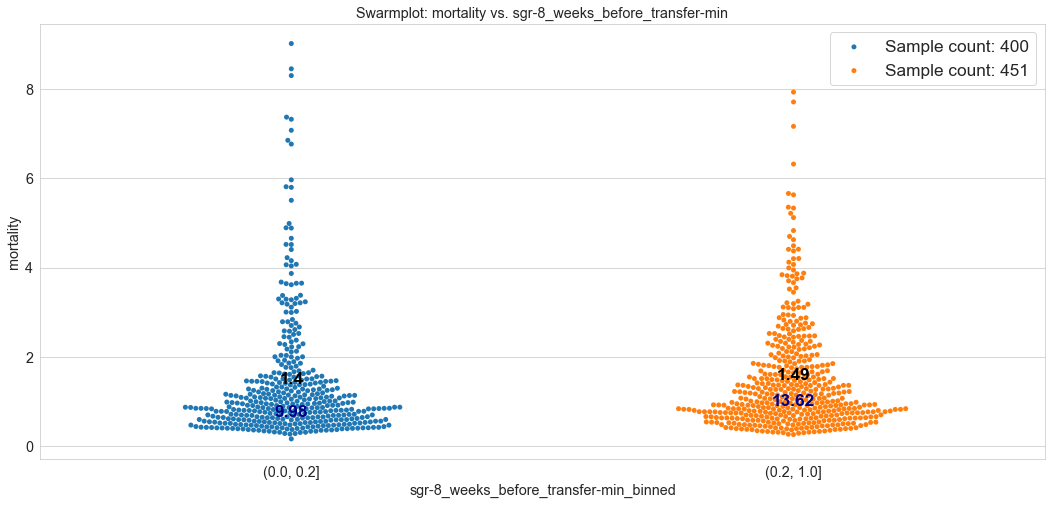

<Figure size 1080x360 with 0 Axes>

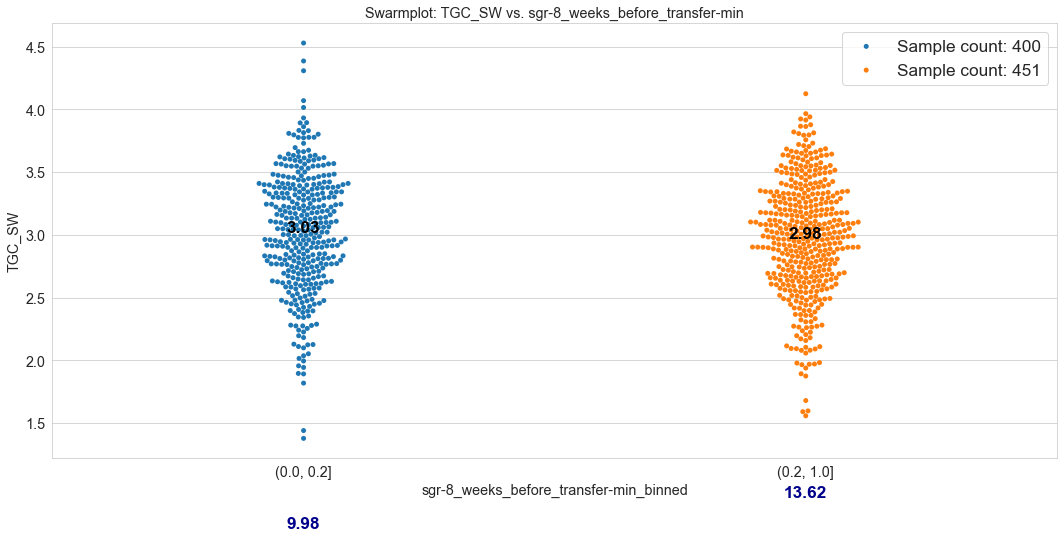

In [86]:
factor = f'{main_factor.lower()}-8_weeks_before_transfer-min'

sgr_factors[sgr_factors[factor].between(0, 1)][factor].hist()
plt.show()

plot_swarm(sgr_factors,
           factor=factor,
           target='mortality',
           bins=(0, 0.2, 1),
           y_scale=15)

plot_swarm(sgr_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 0.2, 1),
           y_scale=15)